# Recovery of gold from ore

The goal of the project is to set up 2 models that would predict 2 recovery parameters (enrichment efficiency). 1 model - recovery after flotation, 2 model - recovery after 2 stages of purification, i.e. from rough concentrate to final concentrate.

The model quality metric will be sMAPE, calculated first for each model separately, and then the final one, calculated using the formula 0.25*sMAPE roung + 0.75sMAPE final


## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer, mean_absolute_error,r2_score, mean_squared_error,recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('gold_industry_train.csv')
df_test = pd.read_csv('gold_industry_test.csv')
df_all = pd.read_csv('gold_industry_full.csv')

In [5]:
df_train.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [6]:
df_test.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [7]:
df_all.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [11]:
df_train.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


In [12]:
df_test.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


In [13]:
df_all.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


Let's evaluate which columns are missing in df_test

In [14]:
train_columns = df_train.columns.values.tolist()
test_columns = df_test.columns.values.tolist()

In [15]:
diff = [x for x in train_columns if x not in test_columns]

In [16]:
len(diff)

34

In [17]:
diff

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

Conclusion after reading the data. In the test sample from the client, unlike the training sample, there are 34 columns missing. Since all these columns are the final values ​​with the concentrations of substances after flotation or purification, as well as the saturation coefficient, we can conclude that these are exactly the features that are not needed for training the model.

Сalculate recovery in the training set, make sure that it is calculated correctly using the MAE metric

In [18]:
df_train['recovry_rougher_my'] = (df_train['rougher.output.concentrate_au']*(
    df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au']))/(
    df_train['rougher.input.feed_au']*(
        df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']))*100

In [19]:
df_train['recovry_final_my'] = df_train['final.output.concentrate_au']*(
    df_train['rougher.input.feed_au'] - df_train['final.output.tail_au'])/(
    df_train['rougher.input.feed_au']*(
        df_train['final.output.concentrate_au'] - df_train['final.output.tail_au']))*100

In [20]:
#Let's take a look at the tables after the calculation
df_train['recovry_rougher_my'], df_train['rougher.output.recovery']

(0        87.107763
 1        86.843261
 2        86.842308
 3        87.226430
 4        86.688794
            ...    
 14574    87.684717
 14575    90.677361
 14576    89.574376
 14577    87.724007
 14578    88.890579
 Name: recovry_rougher_my, Length: 14579, dtype: float64,
 0        87.107763
 1        86.843261
 2        86.842308
 3        87.226430
 4        86.688794
            ...    
 14574    87.684717
 14575    90.677361
 14576    89.574376
 14577    87.724007
 14578    88.890579
 Name: rougher.output.recovery, Length: 14579, dtype: float64)

In [21]:
df_train['recovry_final_my'], df_train['final.output.recovery']

(0        70.541216
 1        69.266198
 2        68.116445
 3        68.347543
 4        66.927016
            ...    
 14574    64.054699
 14575    68.643324
 14576    73.755150
 14577    69.049291
 14578    67.002189
 Name: recovry_final_my, Length: 14579, dtype: float64,
 0        70.541216
 1        69.266198
 2        68.116445
 3        68.347543
 4        66.927016
            ...    
 14574    64.054699
 14575    68.643324
 14576    73.755150
 14577    69.049291
 14578    67.002189
 Name: final.output.recovery, Length: 14579, dtype: float64)

In [22]:
mae_recovery = mean_absolute_error(df_train['rougher.output.recovery'], df_train['recovry_rougher_my'])
mae_recovery

9.83758577644259e-15

In [23]:
mae_recovery_final = mean_absolute_error(df_train['final.output.recovery'], df_train['recovry_final_my'])
mae_recovery_final

8.569602032360358e-15

Based on the calculated values, we see that the values ​​are very small, which means that the recovery table is presented correctly (there are differences, but they are minimal or sporadic).

# Processing passes

In [24]:
df_train.isnull().sum()

date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
recovry_rougher_my         0
recovry_final_my           0
Length: 89, dtype: int64

Let's fill in the gaps with values close to the values of neighboring records. Using the KNNimputer function

In [25]:
#delete the date column, it is not needed
df_train = df_train.drop('date', axis=1)

In [26]:
x = df_train
imputer = KNNImputer(n_neighbors=5)
x1 = imputer.fit_transform(x)
train_final = pd.DataFrame(x1, columns=df_train.columns)

In [27]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14579 non-null  float64
 3   rougher.input.feed_sol                              14579 non-null  float64
 4   rougher.input.feed_rate                             14579 non-null  float64
 5   rougher.input.feed_size                             14579 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14579 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14579 non-null  float64
 8   rougher.state.floatbank10_a_air                     14579 non-null  float64


## Data analysis


Let's estimate what outliers the target value has (column recovery)

<AxesSubplot:>

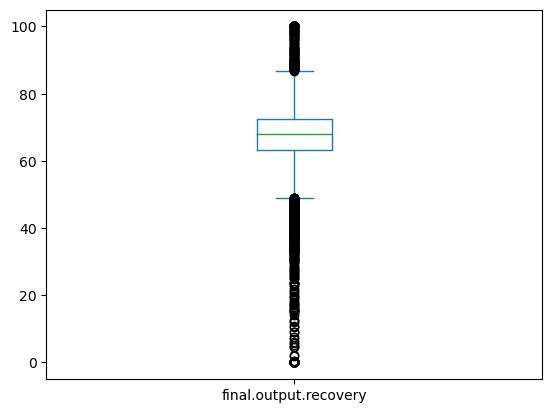

In [28]:
train_final['final.output.recovery'].plot.box()

<AxesSubplot:>

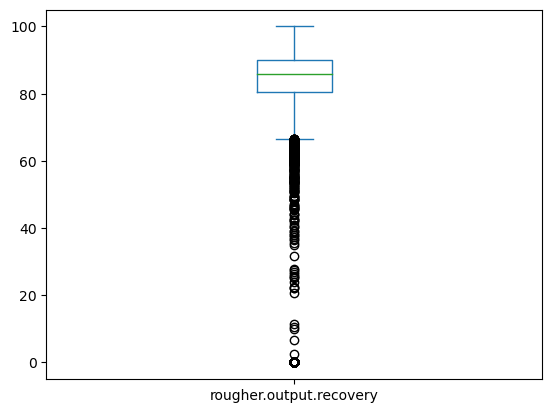

In [29]:
train_final['rougher.output.recovery'].plot.box()

Zero values that are out of the general distribution are suspicious. They look like either a measurement error or random pieces of ore that cannot be considered gold-bearing. It may no longer be necessary to remove non-zero but rather rare observations from the sample. Depends on whether we want to try to train the model to recognize this rare group of observations and make more accurate predictions for them, or whether we don't want to.

List of values not included in the test sample.

In [30]:
not_in_test_df = df_train[diff]

In [31]:
not_in_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       14578 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  14578 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  14578 non-null  float64
 3   rougher.calculation.au_pb_ratio                     14579 non-null  float64
 4   rougher.output.concentrate_au                       14579 non-null  float64
 5   rougher.output.concentrate_ag                       14579 non-null  float64
 6   rougher.output.concentrate_pb                       14579 non-null  float64
 7   rougher.output.concentrate_sol                      14561 non-null  float64
 8   rougher.output.recovery                             14579 non-null  float64


Analyzing the data, we can conclude that these are the parameters that are obtained during the ore purification process. That is, we can say that these are online metrics. And plus the calculated metrics, which we also obtain using online metrics. This is the data that we cannot obtain at the very first, zero stage. Because we make predictions at the zero stage, knowing only the characteristics of the original ore, we do not and cannot have this data, that’s why they are not in the test set and therefore we removed them from the training sample - so that there is no data leakage

2.1.See how the concentration of metals (Au, Ag, Pb) changes at different stages of purification (customer request)

Let's see how the concentration of gold changed

<function matplotlib.pyplot.show(close=None, block=None)>

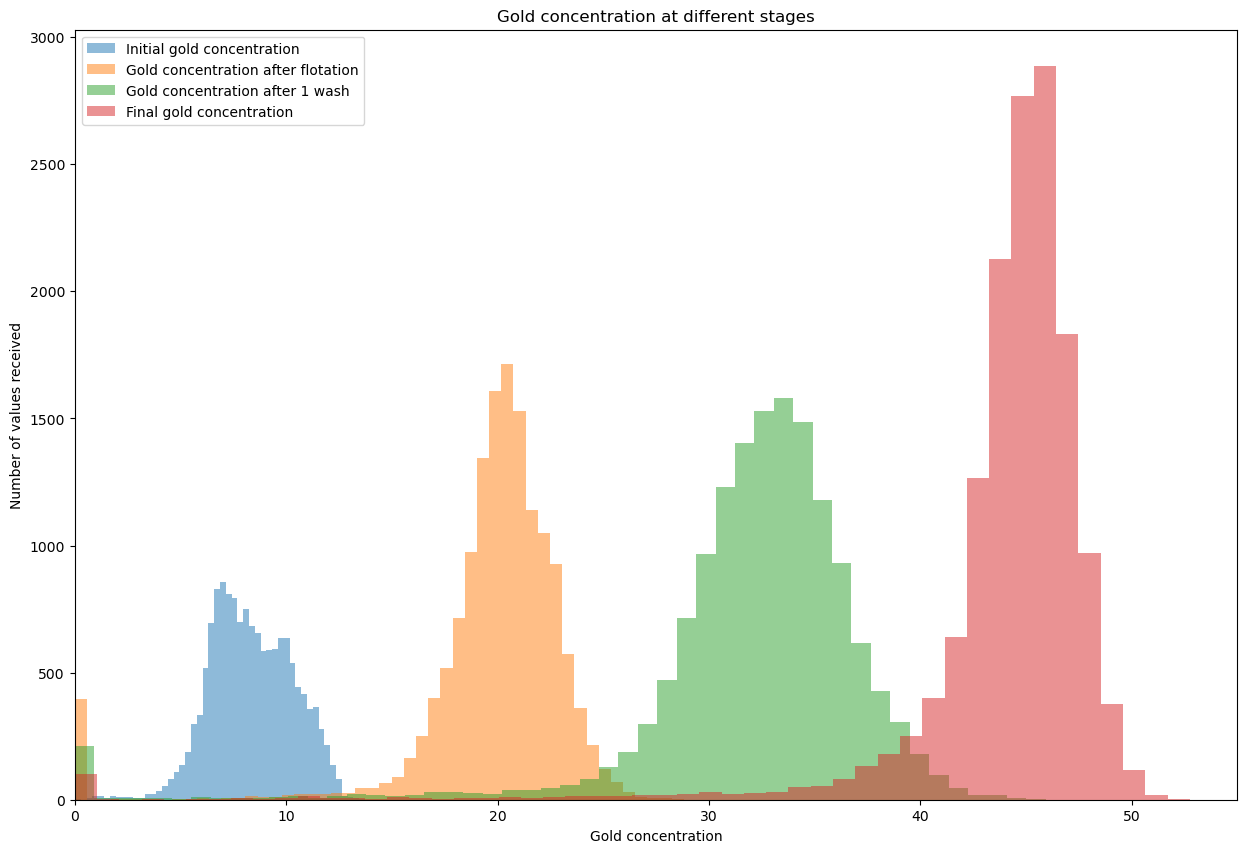

In [32]:
plt.figure(figsize = (15,10))
plt.hist(train_final['rougher.input.feed_au'], bins=50, alpha=0.5 , label= 'Ιnitial gold concentration')
plt.hist(train_final['rougher.output.concentrate_au'], bins=50, alpha=0.5 , label= 'Gold concentration after flotation')
plt.hist(train_final['primary_cleaner.output.concentrate_au'], bins=50, alpha=0.5 , label='Gold concentration after 1 wash')
plt.hist(train_final['final.output.concentrate_au'], bins=50, alpha=0.5 , label= 'Final gold concentration')

plt.xlabel('Gold concentration')
plt.ylabel('Number of values received')
plt.title('Gold concentration at different stages')
plt.xlim([0,55])

plt.legend()

plt.show



We see zero values and that the concentration of gold increases after each stage of purification. The distribution of concentrations looks like a normal distribution.

Silver concentrations analsyis


<function matplotlib.pyplot.show(close=None, block=None)>

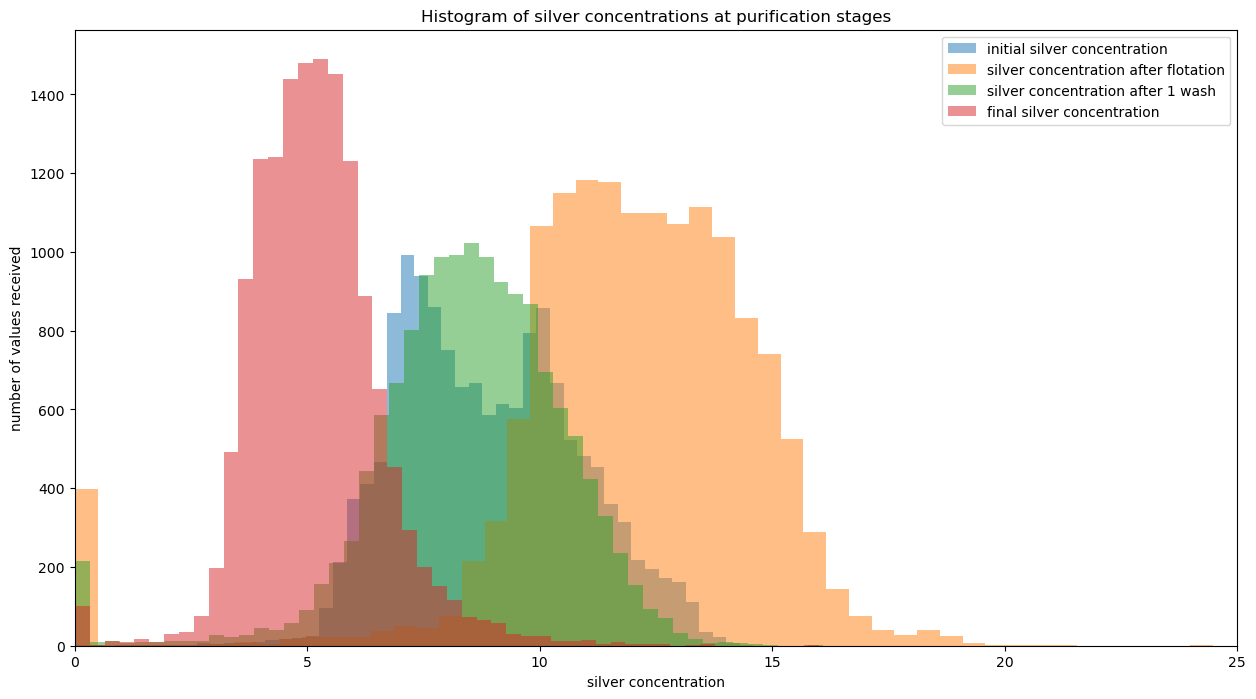

In [33]:
plt.figure(figsize=(15,8))
plt.hist(train_final['rougher.input.feed_ag'], bins=50, alpha=0.5,label='initial silver concentration')
plt.hist(train_final['rougher.output.concentrate_ag'], bins= 50, alpha=0.5, label = 'silver concentration after flotation')
plt.hist(train_final['primary_cleaner.output.concentrate_ag'], bins=50, alpha=0.5, label='silver concentration after 1 wash')
plt.hist(train_final['final.output.concentrate_ag'], bins=50, alpha=0.5, label='final silver concentration')

plt.xlabel('silver concentration')
plt.ylabel('number of values received')

plt.title('Histogram of silver concentrations at purification stages')
plt.legend()
plt.xlim([0,25])
plt.show




The final concentration of silver is the lowest, and after flotation it is the highest.

Lead concentration analysis

<function matplotlib.pyplot.show(close=None, block=None)>

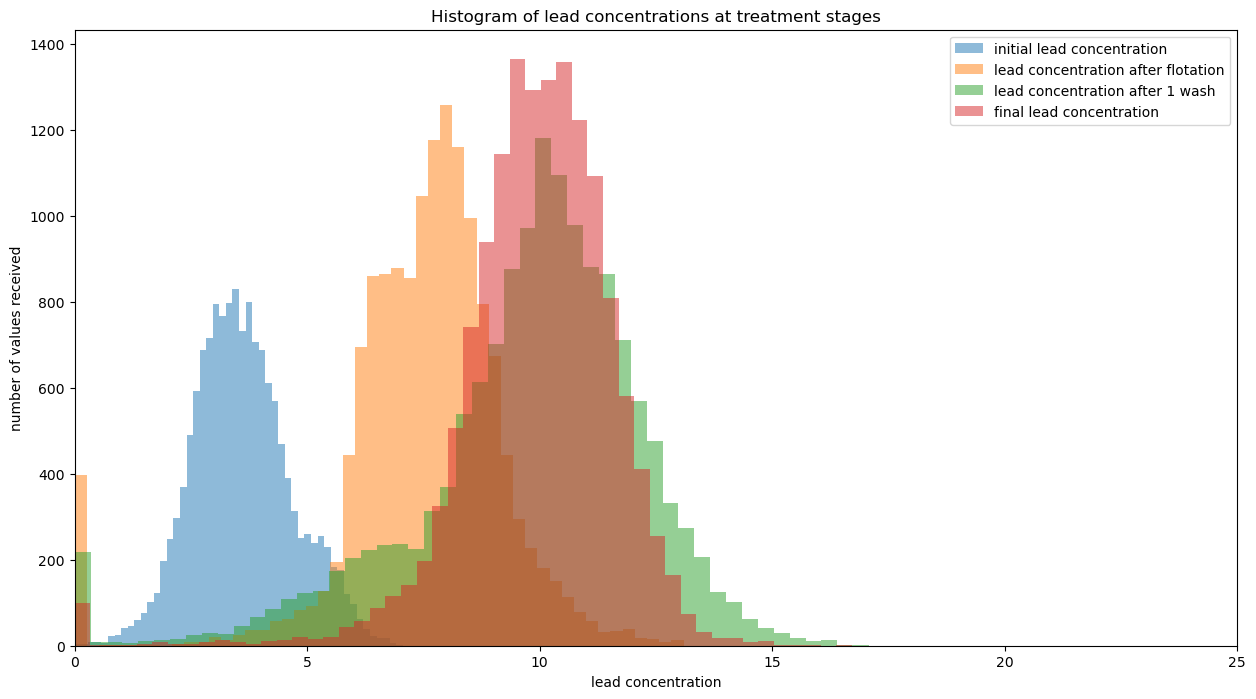

In [34]:
plt.figure(figsize=(15,8))

plt.hist(train_final['rougher.input.feed_pb'], bins=50, alpha=0.5,label='initial lead concentration')
plt.hist(train_final['rougher.output.concentrate_pb'], bins= 50, alpha=0.5, label = 'lead concentration after flotation')
plt.hist(train_final['primary_cleaner.output.concentrate_pb'], bins=50, alpha=0.5, label='lead concentration after 1 wash')
plt.hist(train_final['final.output.concentrate_pb'], bins=50, alpha=0.5, label='final lead concentration')

plt.xlabel('lead concentration')
plt.ylabel('number of values received')

plt.title('Histogram of lead concentrations at treatment stages')
plt.legend()
plt.xlim([0,25])
plt.show

We see that the lead concentration eventually increases. This is due to the fact that lead is the carrier metal of gold. We conclude that from the initial concentrations of metals in the ore, we can guess what the final concentration of gold and lead (as a carrier) will be.

2.2. Comparison of the size distribution of raw material granules on training and test samples. If the distributions are very different from each other, the model estimation will be incorrect (customer request)

<function matplotlib.pyplot.show(close=None, block=None)>

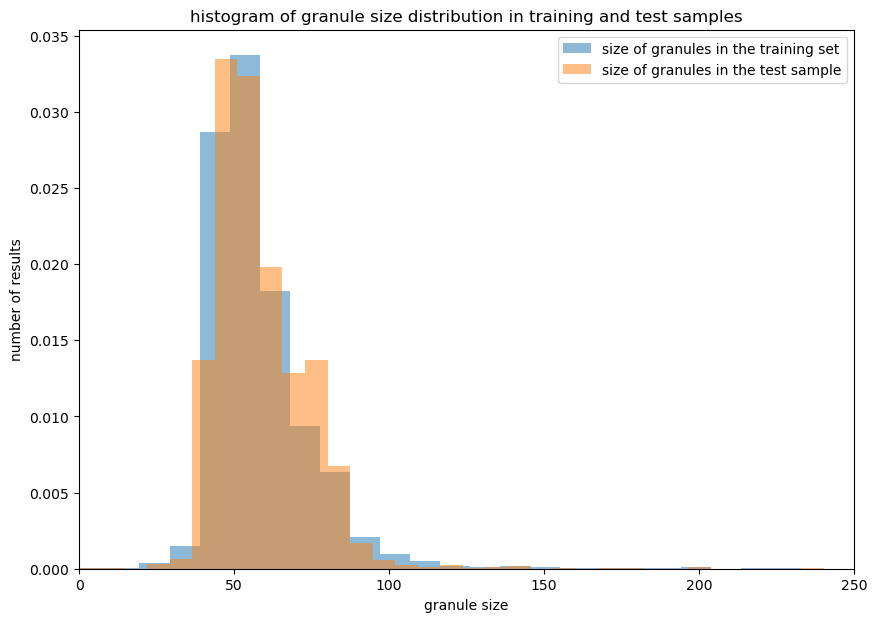

In [35]:
plt.figure(figsize=(10,7))
plt.hist(train_final['rougher.input.feed_size'],bins=50, alpha=0.5, density = True, label='size of granules in the training set')
plt.hist(df_test['rougher.input.feed_size'], bins=50, alpha=0.5, density = True, label ='size of granules in the test sample' )
plt.legend()
plt.xlabel('granule size')
plt.ylabel('number of results')
plt.title('histogram of granule size distribution in training and test samples')
plt.xlim([0,250])
plt.show

In [36]:
df_train['rougher.input.feed_size'].mean()


58.92271219189495

In [37]:
df_test['rougher.input.feed_size'].mean()

59.11339962327549

The distributions are approximately the same.

2.3. Study of the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.

In [38]:
sum_input_train = train_final['rougher.input.feed_ag']\
                   + train_final['rougher.input.feed_pb'] + train_final['rougher.input.feed_au']


In [39]:
sum_after_rougher_train = train_final['rougher.output.concentrate_ag']\
    + train_final['rougher.output.concentrate_pb'] + train_final['rougher.output.concentrate_au']


In [40]:
sum_after_1cl_train = train_final['primary_cleaner.output.concentrate_ag']\
    + train_final['primary_cleaner.output.concentrate_pb'] + train_final['primary_cleaner.output.concentrate_au']


In [41]:
sum_final_train = train_final['final.output.concentrate_ag']\
    + train_final['final.output.concentrate_pb'] + train_final['final.output.concentrate_au']


<function matplotlib.pyplot.show(close=None, block=None)>

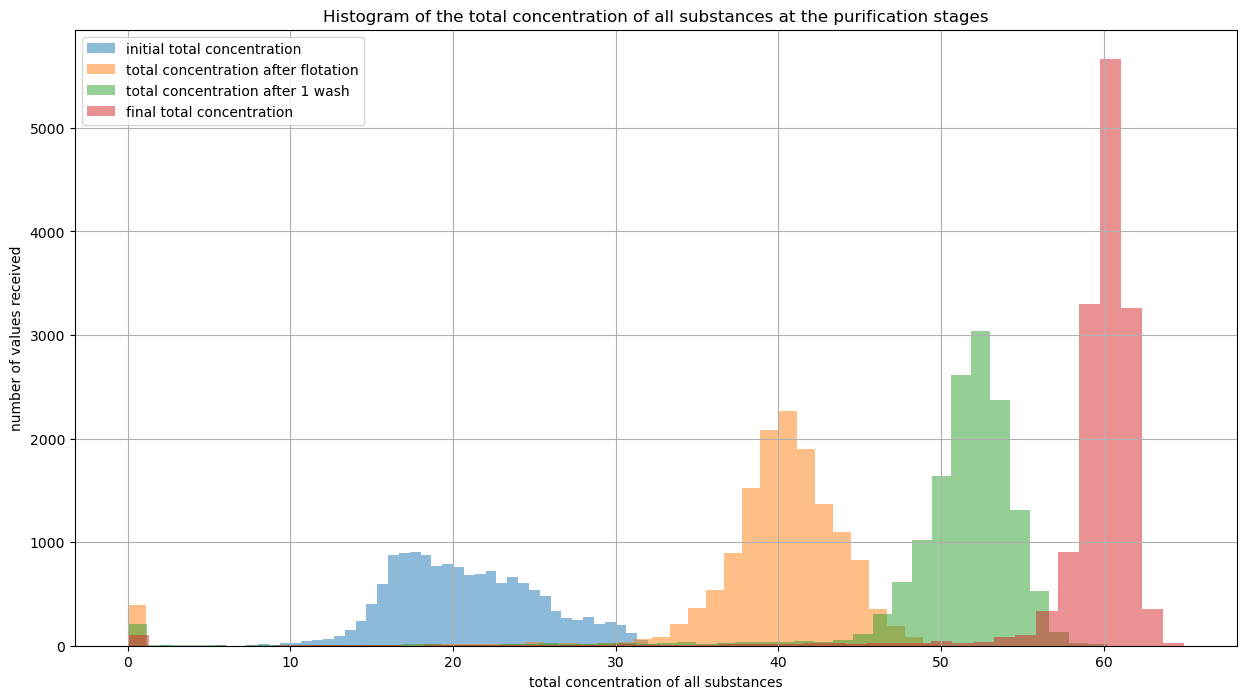

In [42]:
plt.figure(figsize=(15,8))

sum_input_train.hist(bins=50, alpha=0.5,label='initial total concentration')
sum_after_rougher_train.hist( bins= 50, alpha=0.5, label = 'total concentration after flotation')
sum_after_1cl_train.hist( bins=50, alpha=0.5, label='total concentration after 1 wash')
sum_final_train.hist(bins=50, alpha=0.5, label='final total concentration')

plt.xlabel('total concentration of all substances')
plt.ylabel('number of values ​​received')

plt.title('Histogram of the total concentration of all substances at the purification stages')
plt.legend()
plt.show

Concentrations increase as the purification stages progress, and the spread in concentrations becomes smaller and smaller with each stage. However, zero values are visible. Separately for each substance there may be (there are not always grains of gold in the ore), but in total they are unlikely (there will be at least something in the ore). And if we have anomalies, then there is a high probability of inaccuracy in the measurements.They should be removed

In [43]:
#at first delite it from the input part
train_final['sum_input_train'] = train_final['rougher.input.feed_ag']\
    +train_final['rougher.input.feed_pb'] + train_final['rougher.input.feed_au']

In [44]:
list_del = train_final['sum_input_train']<1

In [45]:
train_final[list_del]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,recovry_rougher_my,recovry_final_my,sum_input_train
12626,0.01,0.01,0.01,0.01,602.530096,80.935301,12.473082,7.004836,1401.025067,-299.969743,...,9.389648,8.731319,100.0,0.0,0.0,0.0,0.0,100.0,100.0,0.03
12627,0.01,0.01,0.01,0.01,609.936421,81.143699,12.465643,7.000502,1398.316802,-299.822231,...,9.389648,8.731319,100.0,0.0,0.0,0.0,0.0,100.0,100.0,0.03
12628,0.01,0.01,0.01,0.01,584.285584,80.737541,12.479808,6.996583,1399.833188,-300.415860,...,9.389648,8.731319,100.0,0.0,0.0,0.0,0.0,100.0,100.0,0.03


In [46]:
len(train_final)

14579

In [47]:
train_final = train_final.drop(train_final[list_del].index)

In [48]:
len(train_final)

14576

In [49]:
# now after rougher
train_final['sum_after_rougher_train'] = train_final['rougher.output.concentrate_ag']\
+ train_final['rougher.output.concentrate_pb'] + train_final['rougher.output.concentrate_au']

In [50]:
list_del = train_final['sum_after_rougher_train']<1

In [51]:
train_final[list_del]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,recovry_rougher_my,recovry_final_my,sum_input_train,sum_after_rougher_train
36,7.114065,7.521974,2.811569,41.154430,581.605260,65.620714,13.322740,7.504592,999.026619,-499.850895,...,4.588698,68.403877,2.509776,10.705777,1.509070,17.875134,-0.0,68.403877,17.447608,0.0
37,7.651522,7.313187,2.973841,41.983063,562.972841,66.014780,14.433889,7.583598,999.846655,-500.082738,...,5.274175,70.675633,2.540843,10.728531,1.641216,18.349339,-0.0,70.675633,17.938550,0.0
38,5.587750,7.934791,1.763437,34.446840,229.379445,40.601032,10.865871,5.648950,1003.354806,-501.078303,...,5.688961,55.088448,2.686782,10.694584,1.671644,17.910312,-0.0,55.088448,15.285978,0.0
39,4.752992,7.756881,1.025762,11.816724,228.510521,41.248945,5.908582,5.048482,998.548594,-500.170221,...,7.769770,41.962008,2.889469,11.975654,1.846558,8.138408,-0.0,41.962008,13.535634,0.0
40,5.122801,5.393466,1.824835,28.380274,550.606559,45.329106,10.060214,7.758600,1000.013401,-499.520359,...,5.965126,49.884856,2.739224,10.381465,1.024030,12.974257,-0.0,49.884856,12.341101,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12134,7.951063,8.576019,2.607144,38.972270,570.495631,83.488615,9.393174,6.199710,1401.356444,-300.054420,...,8.191698,83.597741,1.515512,8.853800,0.717677,13.399798,-0.0,83.597741,19.134226,0.0
12135,8.715784,8.640039,2.905023,39.239893,581.010329,83.286682,9.974236,6.198513,1401.413087,-299.653521,...,8.326773,84.738648,1.573222,8.503813,0.757507,13.591903,-0.0,84.738648,20.260847,0.0
12136,9.026122,8.769059,3.020251,39.314207,573.666121,82.826034,10.496884,6.346330,1395.909178,-300.346614,...,8.173988,73.519948,2.760905,8.846540,1.479231,13.094763,-0.0,73.519948,20.815431,0.0
12137,8.752430,8.705607,2.881386,38.927725,590.638687,81.400786,9.966670,6.399316,1400.365227,-299.762683,...,8.396492,78.415342,2.198065,8.485093,1.155559,13.380461,-0.0,78.415342,20.339423,0.0


In [52]:
train_final = train_final.drop(train_final[list_del].index)

In [53]:
len(train_final)

14182

In [54]:
#after first clean
train_final['sum_after_1cl_train'] = train_final['primary_cleaner.output.concentrate_ag']+ train_final['primary_cleaner.output.concentrate_pb'] + train_final['primary_cleaner.output.concentrate_au']

In [55]:
list_del = train_final['sum_after_1cl_train']<1

In [56]:
train_final = train_final.drop(train_final[list_del].index)

In [57]:
len(train_final)

13978

In [58]:
train_final['sum_final_train'] = train_final['final.output.concentrate_ag']\
+ train_final['final.output.concentrate_pb'] + train_final['final.output.concentrate_au']

In [59]:
list_del = train_final['sum_final_train']<1

In [60]:
train_final = train_final.drop(train_final[list_del].index)

In [61]:
len(train_final)

13883

<function matplotlib.pyplot.show(close=None, block=None)>

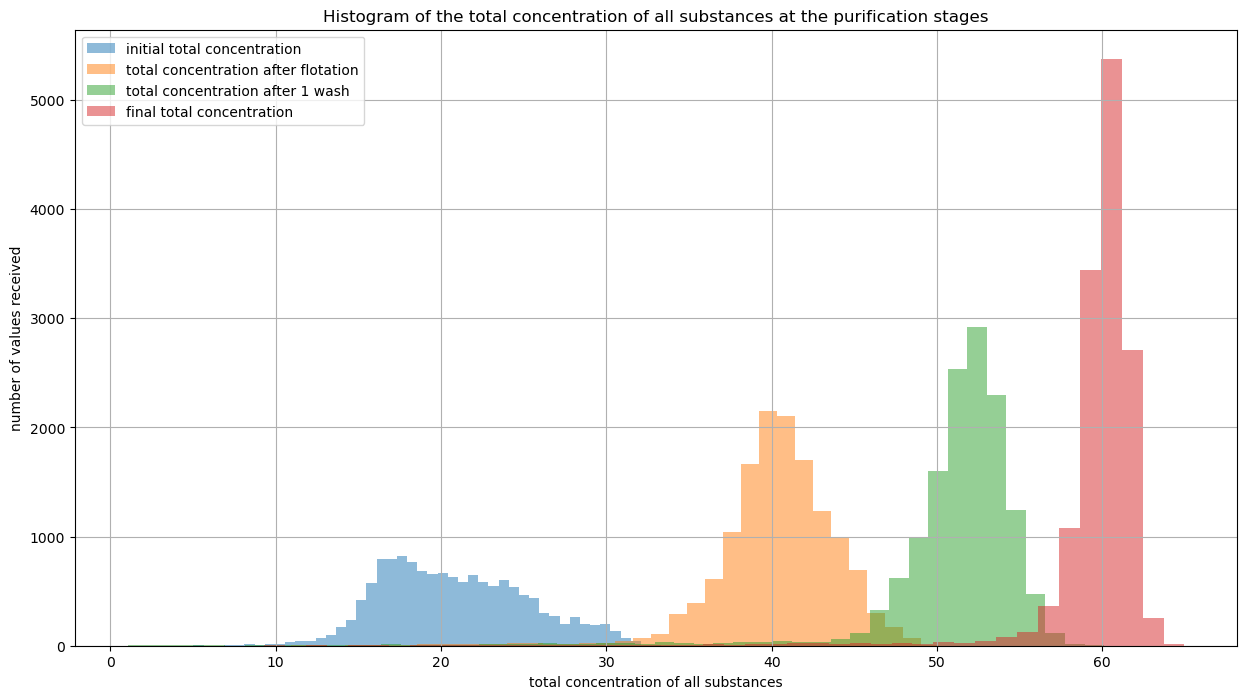

In [62]:
plt.figure(figsize=(15,8))

train_final['sum_input_train'].hist(bins=50, alpha=0.5,label='initial total concentration')
train_final['sum_after_rougher_train'].hist( bins= 50, alpha=0.5, label = 'total concentration after flotation')
train_final['sum_after_1cl_train'].hist( bins=50, alpha=0.5, label='total concentration after 1 wash')
train_final['sum_final_train'].hist(bins=50, alpha=0.5, label='final total concentration')

plt.xlabel('total concentration of all substances')
plt.ylabel('number of values received')

plt.title('Histogram of the total concentration of all substances at the purification stages')
plt.legend()
plt.show

Thanks to the summation, zero values ​​were found that could distort ml learning. Now we don’t need these total values

In [63]:
train_final = train_final.drop('sum_input_train', axis=1)

In [64]:
train_final = train_final.drop('sum_after_1cl_train', axis=1)

In [65]:
train_final = train_final.drop('sum_after_rougher_train', axis=1)

In [66]:
train_final = train_final.drop('sum_final_train', axis=1)

In [67]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               13883 non-null  float64
 1   rougher.input.feed_ag                               13883 non-null  float64
 2   rougher.input.feed_pb                               13883 non-null  float64
 3   rougher.input.feed_sol                              13883 non-null  float64
 4   rougher.input.feed_rate                             13883 non-null  float64
 5   rougher.input.feed_size                             13883 non-null  float64
 6   rougher.input.floatbank10_sulfate                   13883 non-null  float64
 7   rougher.input.floatbank10_xanthate                  13883 non-null  float64
 8   rougher.state.floatbank10_a_air                     13883 non-null  float64


##  Build a model



3.1. Write a function to calculate the final sMAPE.

In [68]:
def sMare_func (target, predict):
    x = abs(target-predict)
    y = (abs(target)+abs(predict))/2
    sMARE = (x/y).mean()*100
    return sMARE

In [69]:
def final_sMARE (sMARE_rougher, sMARE_end):
    SMARE = sMARE_rougher*0.25 + sMARE_end*0.75
    return SMARE

3.2. Train different models and evaluate their quality through cross-validation. Select the best model and test it on a test set.

Let's decide on the signs and targets.
We have a list of metrics (diff), which are online metrics (obtained during the cleaning process). We don't need them to train models.
For a model predicting the coefficient after flotation, the target will be the rougher.output.recovery column, and the attributes will be all the attributes remaining after deleting online metrics with the mention rougher/

for a model predicting the final coefficient, the final.output.recovery column will be the target.

Plan: first we will get a dataframe with all the necessary features, then we will select the features for the model that predicts the coefficients after flotation, combine the necessary features with the necessary targets and divide the volume of sampling into training and validation. Then select the targets

In [70]:
train_final = train_final.drop(['recovry_rougher_my','recovry_final_my'], axis=1)

In [71]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               13883 non-null  float64
 1   rougher.input.feed_ag                               13883 non-null  float64
 2   rougher.input.feed_pb                               13883 non-null  float64
 3   rougher.input.feed_sol                              13883 non-null  float64
 4   rougher.input.feed_rate                             13883 non-null  float64
 5   rougher.input.feed_size                             13883 non-null  float64
 6   rougher.input.floatbank10_sulfate                   13883 non-null  float64
 7   rougher.input.floatbank10_xanthate                  13883 non-null  float64
 8   rougher.state.floatbank10_a_air                     13883 non-null  float64


In [72]:
df_all_train = train_final.drop(diff, axis=1)

In [73]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       13883 non-null  float64
 1   rougher.input.feed_ag                       13883 non-null  float64
 2   rougher.input.feed_pb                       13883 non-null  float64
 3   rougher.input.feed_sol                      13883 non-null  float64
 4   rougher.input.feed_rate                     13883 non-null  float64
 5   rougher.input.feed_size                     13883 non-null  float64
 6   rougher.input.floatbank10_sulfate           13883 non-null  float64
 7   rougher.input.floatbank10_xanthate          13883 non-null  float64
 8   rougher.state.floatbank10_a_air             13883 non-null  float64
 9   rougher.state.floatbank10_a_level           13883 non-null  float64
 10  rougher.st

highlight the signs for flotation

In [74]:
list_for_rougher = []
for i in df_all_train:
    if 'rougher' in i:
        list_for_rougher.append(i) 

In [75]:
df_rougher = df_all_train.loc[:,list_for_rougher]

In [76]:
df_rougher['rougher.output.recovery'] = train_final['rougher.output.recovery']

In [77]:
df_all_train['final.output.recovery'] = train_final['final.output.recovery']

In [78]:
df_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_au               13883 non-null  float64
 1   rougher.input.feed_ag               13883 non-null  float64
 2   rougher.input.feed_pb               13883 non-null  float64
 3   rougher.input.feed_sol              13883 non-null  float64
 4   rougher.input.feed_rate             13883 non-null  float64
 5   rougher.input.feed_size             13883 non-null  float64
 6   rougher.input.floatbank10_sulfate   13883 non-null  float64
 7   rougher.input.floatbank10_xanthate  13883 non-null  float64
 8   rougher.state.floatbank10_a_air     13883 non-null  float64
 9   rougher.state.floatbank10_a_level   13883 non-null  float64
 10  rougher.state.floatbank10_b_air     13883 non-null  float64
 11  rougher.state.floatbank10_b_level   13883

In [79]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13883 entries, 0 to 14578
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       13883 non-null  float64
 1   rougher.input.feed_ag                       13883 non-null  float64
 2   rougher.input.feed_pb                       13883 non-null  float64
 3   rougher.input.feed_sol                      13883 non-null  float64
 4   rougher.input.feed_rate                     13883 non-null  float64
 5   rougher.input.feed_size                     13883 non-null  float64
 6   rougher.input.floatbank10_sulfate           13883 non-null  float64
 7   rougher.input.floatbank10_xanthate          13883 non-null  float64
 8   rougher.state.floatbank10_a_air             13883 non-null  float64
 9   rougher.state.floatbank10_a_level           13883 non-null  float64
 10  rougher.st

In [80]:
rougher_train_target = df_rougher['rougher.output.recovery']
rougher_train_features = df_rougher.drop('rougher.output.recovery', axis=1)

Scaling the features

In [81]:
numeric = rougher_train_features.columns
mmscaler = MinMaxScaler()

rougher_train_features[numeric] = mmscaler.fit_transform(rougher_train_features[numeric])




In [82]:
rougher_train_features

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate
0,0.433422,0.369717,0.311708,0.685601,0.729671,0.114323,0.331850,0.619138,0.661060,0.660854,...,0.641181,0.577789,0.879957,0.344578,0.730770,0.378829,0.830328,0.432118,0.311650,0.619247
1,0.432830,0.374223,0.308982,0.665696,0.732102,0.118019,0.331423,0.618909,0.661443,0.671271,...,0.640423,0.556331,0.880831,0.346922,0.728045,0.387866,0.820593,0.436091,0.315848,0.619945
2,0.423731,0.370910,0.293619,0.669813,0.738703,0.118497,0.330022,0.638657,0.661069,0.671248,...,0.640100,0.555982,0.880458,0.346921,0.728021,0.389700,0.820943,0.435200,0.313850,0.639747
3,0.404647,0.365483,0.276032,0.686613,0.756213,0.119079,0.321979,0.639254,0.661132,0.670919,...,0.640236,0.556106,0.879290,0.346613,0.728937,0.389518,0.820895,0.436807,0.307851,0.638917
4,0.369106,0.366789,0.239804,0.639179,0.753344,0.115479,0.303363,0.638806,0.661042,0.672084,...,0.640374,0.555758,0.880409,0.346999,0.729258,0.391786,0.821437,0.435462,0.288580,0.638743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14574,0.285887,0.349070,0.596217,0.698276,0.780331,0.175695,0.187576,0.928060,0.793800,0.931707,...,0.421045,0.415684,0.521443,0.259491,0.442785,0.291259,0.498995,0.330026,0.178386,0.928074
14575,0.290469,0.350756,0.594198,0.696674,0.782519,0.172836,0.187429,0.927593,0.794133,0.931704,...,0.419950,0.414922,0.528853,0.259995,0.442570,0.289989,0.499184,0.325699,0.178292,0.928160
14576,0.343469,0.369084,0.648482,0.696187,0.781716,0.176667,0.214901,0.943848,0.793001,0.929539,...,0.419345,0.419629,0.521195,0.260909,0.442502,0.292746,0.498772,0.332803,0.204490,0.944078
14577,0.304584,0.371271,0.580255,0.719235,0.779128,0.246330,0.203658,0.958930,0.791231,0.933009,...,0.419586,0.412539,0.522918,0.259387,0.441904,0.290631,0.498921,0.334170,0.186817,0.958705


We divide the data for the final prediction into training and validation samples

In [83]:
final_train_target = df_all_train['final.output.recovery']
final_train_features = df_all_train.drop('final.output.recovery', axis=1)

Scaling the features

In [84]:
numeric = final_train_features.columns
mmscaler = MinMaxScaler()

final_train_features[numeric] = mmscaler.fit_transform(final_train_features[numeric])




In [85]:
final_train_features

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.433422,0.369717,0.311708,0.685601,0.729671,0.114323,0.331850,0.619138,0.661060,0.660854,...,0.465432,0.536120,0.503998,0.373418,0.233603,0.540868,0.275626,0.452465,0.441013,0.297042
1,0.432830,0.374223,0.308982,0.665696,0.732102,0.118019,0.331423,0.618909,0.661443,0.671271,...,0.464617,0.530683,0.497775,0.377685,0.236180,0.537504,0.272162,0.452297,0.436272,0.305862
2,0.423731,0.370910,0.293619,0.669813,0.738703,0.118497,0.330022,0.638657,0.661069,0.671248,...,0.465372,0.536061,0.496202,0.377935,0.236899,0.537578,0.273225,0.452395,0.437212,0.303473
3,0.404647,0.365483,0.276032,0.686613,0.756213,0.119079,0.321979,0.639254,0.661132,0.670919,...,0.466086,0.539061,0.499816,0.377859,0.234618,0.539256,0.271891,0.452790,0.436495,0.305558
4,0.369106,0.366789,0.239804,0.639179,0.753344,0.115479,0.303363,0.638806,0.661042,0.672084,...,0.465780,0.540898,0.497880,0.378036,0.233605,0.534761,0.268858,0.452639,0.436219,0.303372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14574,0.285887,0.349070,0.596217,0.698276,0.780331,0.175695,0.187576,0.928060,0.793800,0.931707,...,0.764748,0.538449,0.834493,0.379564,0.416804,0.538043,0.455152,0.453134,0.622484,0.449993
14575,0.290469,0.350756,0.594198,0.696674,0.782519,0.172836,0.187429,0.927593,0.794133,0.931704,...,0.764824,0.538962,0.832577,0.379206,0.417036,0.537647,0.455473,0.452786,0.621764,0.447472
14576,0.343469,0.369084,0.648482,0.696187,0.781716,0.176667,0.214901,0.943848,0.793001,0.929539,...,0.764766,0.538501,0.833374,0.379692,0.416907,0.538111,0.455255,0.452941,0.622507,0.449344
14577,0.304584,0.371271,0.580255,0.719235,0.779128,0.246330,0.203658,0.958930,0.791231,0.933009,...,0.762395,0.537699,0.834544,0.379048,0.416737,0.537097,0.453537,0.453334,0.621288,0.449715


Let's pass the metric to the function so that it can be inserted into Gridsearch

In [86]:
sMAPE_score = make_scorer(sMare_func, greater_is_better = False)

Linear Regression Model for Flotation

In [87]:
ridge = Ridge()

In [88]:
alpha_grid = {'alpha': np.logspace(-4, 4, 20)} # 20 points from 10^(-4) to 10^4
ridge_grid = GridSearchCV(ridge, alpha_grid, cv=5, scoring=sMAPE_score) 
ridge_grid.fit(rougher_train_features, rougher_train_target)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring=make_scorer(sMare_func, greater_is_better=False))

In [89]:
# Let's look at the best performance
print('Best alpha:', ridge_grid.best_params_)
print('\nBest score:', ridge_grid.best_score_)


Best alpha: {'alpha': 78.47599703514607}

Best score: -6.084483431455421


In [90]:
sMAPE_score_L2 = ridge_grid.best_score_

In [91]:
print('sMAPE_score with L2 regularization:', sMAPE_score_L2)

sMAPE_score with L2 regularization: -6.084483431455421


Decision tree


In [92]:
params = {'max_depth':range(2, 10),
          'criterion':['mse', 'mae']}


In [93]:
greedS_tree = RandomizedSearchCV(DecisionTreeRegressor(random_state=2023), params,
                             scoring=sMAPE_score , cv=3, n_iter=16, n_jobs = -1)

In [94]:
%%time

greedS_tree.fit(rougher_train_features, rougher_train_target)

greedS_tree.best_params_



Wall time: 1min 21s


{'max_depth': 2, 'criterion': 'mae'}

In [95]:
sMare_tree_cv = greedS_tree.best_score_

In [96]:
sMare_tree_cv

-6.665899366202869

random forest

In [97]:
forest_params = {'n_estimators':range(1,10),
                 'max_depth':range(1,11),
                 'max_features':range(1, 53),
                 'bootstrap':[True, False],
                 'criterion':['mse', 'mae']
                }

In [98]:
rs_forest = RandomizedSearchCV(RandomForestRegressor(random_state=2023),
                               forest_params, cv = 5, n_iter = 16, scoring = sMAPE_score)

In [99]:

rs_forest.fit(rougher_train_features, rougher_train_target)


rs_forest.best_score_



-6.048599991640414

In [100]:

rs_forest.best_params_


{'n_estimators': 7,
 'max_features': 10,
 'max_depth': 3,
 'criterion': 'mae',
 'bootstrap': True}

In [101]:
Smare_forest_cv = rs_forest.best_score_

In [102]:
print('sMare L2 regularization', sMAPE_score_L2)
print('sMare decision tree with parameter selection and cross-validation',sMare_tree_cv)
print('sMare random forest with parameter selection and cross-validation',Smare_forest_cv)

sMare L2 regularization -6.084483431455421
sMare decision tree with parameter selection and cross-validation -6.665899366202869
sMare random forest with parameter selection and cross-validation -6.048599991640414


Conclusion. selected models for predicting recovery after flotation. The best model according to the results of sMARE-random forest

Selection of model for final recovery

Linear model

In [103]:
ridge_fin = Ridge() 

In [104]:
alpha_grid_fin = {'alpha': np.logspace(-4, 4, 20)} 
ridge_grid_fin = GridSearchCV(ridge_fin, alpha_grid, cv=5, scoring=sMAPE_score) 
ridge_grid_fin.fit(final_train_features, final_train_target)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring=make_scorer(sMare_func, greater_is_better=False))

In [105]:
# Let's look at the best performance
print('Best alpha:', ridge_grid_fin.best_params_)
print('\nBest score:', ridge_grid_fin.best_score_)


Best alpha: {'alpha': 206.913808111479}

Best score: -8.757030266484133


In [106]:
ridge_grid_fin.best_estimator_


Ridge(alpha=206.913808111479)

In [107]:
sMAPE_score_L2_fin =  ridge_grid_fin.best_score_

In [108]:
print('sMAPE_score with L2 regularization:', sMAPE_score_L2_fin)

sMAPE_score with L2 regularization: -8.757030266484133


Decision tree


In [109]:
params = {'max_depth':range(2, 5),
          'criterion':['mse', 'mae']}

In [110]:
final_tree_cv = RandomizedSearchCV(DecisionTreeRegressor(random_state=2023), params,
                             scoring=sMAPE_score , cv=3, n_iter=16, n_jobs = -1)
final_tree_cv.fit(final_train_features, final_train_target)

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=2023),
                   n_iter=16, n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': range(2, 5)},
                   scoring=make_scorer(sMare_func, greater_is_better=False))

In [111]:
final_tree_cv.best_params_


{'max_depth': 2, 'criterion': 'mse'}

In [112]:
sMare_tree_final_cv = final_tree_cv.best_score_ 
sMare_tree_final_cv

-9.579585834020675

random forest

In [113]:
forest_params = {'n_estimators':range(5,8),
                 'max_depth':range(3,6),
                 'max_features':range(10, 25),
                 'bootstrap':[True, False],
                 'criterion':['mse', 'mae']
                }


In [114]:
forest_final_cv = RandomizedSearchCV(RandomForestRegressor(random_state=2023),
                               forest_params, cv = 5, n_iter = 16, scoring = sMAPE_score)


In [115]:
forest_final_cv.fit(final_train_features, final_train_target)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2023),
                   n_iter=16,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': range(3, 6),
                                        'max_features': range(10, 25),
                                        'n_estimators': range(5, 8)},
                   scoring=make_scorer(sMare_func, greater_is_better=False))

In [116]:
Smare_final_forest_cv = forest_final_cv.best_score_


In [117]:
forest_final_cv.best_params_


{'n_estimators': 7,
 'max_features': 15,
 'max_depth': 4,
 'criterion': 'mse',
 'bootstrap': False}

In [118]:
print('sMare L2 regularization', sMAPE_score_L2_fin)
print('sMare decision tree with parameter selection and cross-validation',sMare_tree_final_cv)
print('sMare random forest with parameter selection and cross-validation',Smare_final_forest_cv)

sMare L2 regularization -8.757030266484133
sMare decision tree with parameter selection and cross-validation -9.579585834020675
sMare random forest with parameter selection and cross-validation -8.640497695243695


after flotation, the best model according to the sMARE random forest metric, the final one is a random forest model. let's calculate the final sMARE

In [141]:
end_SMARE = final_sMARE(Smare_forest_cv, Smare_final_forest_cv)

In [142]:
end_SMARE

-7.992523269342875

Now let's check the final SMARE on the test sample

In [121]:
list_data = df_test['date']
df_target_end = df_all.loc[df_all['date'].isin(list_data)]

In [122]:
test_final = df_test.drop('date', axis=1)

In [123]:
x = test_final.columns
test_final[x] = mmscaler.transform(test_final[x])

In [124]:
#fill in the blanks
x = test_final
imputer = KNNImputer(n_neighbors=5)
x1 = imputer.fit_transform(x)
test_final = pd.DataFrame(x1, columns=test_final.columns)

In [125]:
#select the necessary features for flotation from the test sample
df_test_rougher= test_final.loc[:,list_for_rougher]

In [126]:
target_testDF_rougher = df_target_end['rougher.output.recovery']

In [127]:
target_testDF_final = df_target_end['final.output.recovery']

In [143]:
test_rougher_predict = rs_forest.predict(df_test_rougher)


In [144]:
test_rou_smare =  sMare_func(target_testDF_rougher, test_rougher_predict)

In [145]:
test_rou_smare

4.23516531917609

In [146]:
test_final_predict = forest_final_cv.predict(test_final)

In [147]:
test_final_smare =  sMare_func(target_testDF_final, test_final_predict)

In [148]:
test_final_smare

7.6637425058389645

In [149]:
end_test_SMARE = final_sMARE(test_rou_smare,test_final_smare)

In [150]:
end_test_SMARE

6.806598209173246

We obtained 2 models that predict the recovery coefficient after the flotation stage and after completion of the entire purification process. The metric that evaluates the quality of the obtained forecast - SMARE is equal to 4.235 and 7.663 (total - 6.806). Since the customer did not provide the desired quality values, it is difficult to assess how satisfactory this metric is for the business. However, we can do a test on a random model to evaluate the quality of our models' predictions

Let's check what result the constant model will produce

In [137]:
from sklearn.dummy import  DummyRegressor 


In [138]:
dummy_model1 =  DummyRegressor (strategy='mean')
dummy_model1.fit(rougher_train_features, rougher_train_target)
sMARE1 = sMare_func(dummy_model1.predict(df_test_rougher), target_testDF_rougher)
sMARE1

6.101944863418984

In [139]:
dummy_model2 = DummyRegressor (strategy='mean')
dummy_model2.fit(final_train_features, final_train_target)
sMARE2 = sMare_func(dummy_model2.predict(test_final), target_testDF_final)
sMARE2

9.256728336204745

In [140]:
dummy_all_sMARE = final_sMARE(sMARE1, sMARE2)
dummy_all_sMARE

8.468032468008305

The random model showed a higher metric value, which means our models make more accurate predictions.

### Conclusion.

To develop two models predicting gold concentration coefficients after the flotation stage and at the end of the technological process, 3  datasets were provided (training, test and initial). The original dataset contained training and test samples with all signs and targets. The training dataset also contained all the signs and targets, but we should use it in model learning. The test dataset did not contain target features, and also lacked some features that were calculated. Those. arose during the ore purification process.


From the original dataset we obtained target values for the test sample.

Data contained gaps that needed to be processed. Gaps are handled using the nearest neighbor method.

The adequacy of the data was also assessed during the data analysis. The data shows that during the refining process, the concentration of gold increases, the concentration of silver decreases, and the concentration of lead also increases. The total concentration of all substances during the purification process also increases, and the variability of concentrations decreases. All identified dependencies coincide with the expected results, which tells us about the quality of the data from which we can build a machine learning model

Also, during the data analysis, values of zero concentrations of all elements in the ore (gold, silver and lead) were discovered. Most likely, these values were obtained during the process of technological maintenance of cleaning devices or another error. Since a situation where there is not a single gram of these elements in the initial ore is hardly possible in real life, data with zero concentrations were removed from the sample.

The metric measuring the quality of the obtained forecast - SMARE, is equal to 4.235 for the flotation stage and 7.663 for the total stage (total 6.806). Since the customer did not provide the required quality indicators, it is difficult to assess how this indicator will satisfy the business. However, we can run a test on a random model to evaluate the quality of our model's predictions.

The random model showed a higher value of indicators (6.101 for the flotation stage, 9.256 for the final stage, 8.468 total). This means that our models give more accurate forecasts and can be presented to the customer